In [91]:
# from src.datasets import patientDataset, eegDataset
# from src.resnet import ResNet1d
# from src.lstm import Lstm
from tqdm import tqdm
import numpy as np
import mne
from helper_code import *
import matplotlib.pyplot as plt

In [103]:
import numpy as np
from scipy import signal

def psd(eeg_data, fs):
    # Define frequency bands of interest (in Hz)
    freq_bands = {'delta': [0.5, 4],
              'theta': [4, 8],
              'alpha': [8, 12],
              'beta': [12, 30]}

    # Define sampling frequency (in Hz)
    fs = 60

    # Compute PSD and extract power in each frequency band for each epoch
    freqs, psds = signal.welch(eeg_data, fs=fs, nperseg=fs*2)
    band_powers = {}
    for band, freq_range in freq_bands.items():
        freq_mask = (freqs >= freq_range[0]) & (freqs < freq_range[1])
        band_powers[band] = psds[:, freq_mask].mean(axis=0)
        
    return np.concatenate([band_powers[band] for band in freq_bands])

def bsr(eeg_data, sfreq):

    # Define the  duration of the epochs (in seconds)
    epoch_duration = 1

    # Define the frequency band of interest for the BSR computation (in Hz)
    freq_band = [0.5, 25]

    # Define the threshold for the BSR computation as a fraction of the median RMS amplitude
    bsr_threshold = 0.5

    # Filter the EEG data in the frequency band of interest using a Butterworth filter
    nyquist_freq = sfreq / 2
    b, a = signal.butter(4, [freq_band[0] / nyquist_freq, freq_band[1] / nyquist_freq], btype='bandpass')
    filtered_data = signal.filtfilt(b, a, eeg_data)

    # Compute the root mean square (RMS) amplitude of each epoch
    epoch_samples = int(epoch_duration * sfreq)
    n_epochs = filtered_data.shape[-1] // epoch_samples
    epochs = filtered_data[:, :n_epochs * epoch_samples].reshape(18, n_epochs, epoch_samples)
    
    rms_amplitude = np.sqrt(np.mean(epochs ** 2, axis=-1))

    # Compute the median RMS amplitude across all epochs
    median_rms = np.median(rms_amplitude)
#     print(rms_amplitude.shape, median_rms)
    # Compute the percentage of epochs that have an RMS amplitude below the BSR threshold
    bsr = (rms_amplitude < bsr_threshold * median_rms).mean(axis=-1) * 100

    return bsr


In [110]:
import torch
from torch.utils.data import Dataset
from helper_code import *
import numpy as np, os, sys
import librosa
import mne
import torchaudio.transforms as T

from tqdm import tqdm

n_fft = 2048
hop_length = 512
n_mels = 256
n_mfcc = 256


def featurise_recording(location):
    channels = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 
                'T4-T6', 'T6-O2', 'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 
                'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'Fz-Cz', 'Cz-Pz']
    recording_data, sr, cur_channels = load_recording(location)
    signal_data = reorder_recording_channels(recording_data, cur_channels, channels)
    
    resampled_data = librosa.resample(y=signal_data, orig_sr=sr, target_sr=60)
    resampled_data = resampled_data[:, 120*60: 180*60]
    final2 = psd(resampled_data, 60)
    final1 = bsr(resampled_data, 60)
#     final3 = dwt(resampled_data, 60)
    
    final = np.concatenate((final1, final2))
#     print(final.shape)
    
    return final

def featurise_locs(locs):
    fin = []
    fin.append(featurise_recording(locs[0]))
    fin.append(featurise_recording(locs[len(locs)//2]))
    fin.append(featurise_recording(locs[-1]))
    fin = np.array(fin).flatten()
#     print(fin.shape)
    return fin

def featurise_labels(label):
#     print(label)
    tp = np.array([0,0])
    tp[label] = 1
    return tp

class patientDataset(Dataset):
    def __init__(self, data_folder, segs):
        
        self.no_of_segments = segs
        
        self.data_folder  = data_folder
        self.patient_ids  = find_data_folders(data_folder)
        self.num_patients = len(self.patient_ids)
        
        self.inputs = []
        self.outcomes = []
        
        for i in tqdm(range(self.num_patients)):
            inp, out = self.getitemx(i)
#             if inp.shape[0] == self.no_of_segments:
            self.inputs.append(inp)
            self.outcomes.append(out)
#         self.inputs = np.array(self.inputs)
#         self.outcomes = np.array(self.outcomes)
        
    def getMetadata(self, idx):
        # Load data.
        patient_id = self.patient_ids[idx]
        
        # Define file location.
        patient_metadata_file = os.path.join(self.data_folder, patient_id, patient_id + '.txt')
        recording_metadata_file = os.path.join(self.data_folder, patient_id, patient_id + '.tsv')

        # Load non-recording data.
        patient_metadata = load_text_file(patient_metadata_file)
        recording_metadata = load_text_file(recording_metadata_file)
        
        return patient_metadata, recording_metadata
        
    def getitemx(self, index):
        
        patient_metadata, recording_metadata = self.getMetadata(index)
        
        # Load recordings.
        recording_ids = list(get_recording_ids(recording_metadata))
        
        recording_locations = []
        for recording_id in reversed(recording_ids):
            if recording_id != 'nan':
                recording_location = os.path.join(self.data_folder, self.patient_ids[index], recording_id)
                recording_locations.append(recording_location)
            
            if len(recording_locations) >= self.no_of_segments:
                break
        recording_locations.reverse()
        print(len(recording_locations), get_outcome(patient_metadata))
        return featurise_locs(recording_locations), featurise_labels(get_outcome(patient_metadata))
    
    def __getitem__(self, index):
        
        return self.inputs[index], self.outcomes[index]
        
    def __len__(self):
        return self.num_patients

In [111]:
import pywt
import numpy as np

def dwt(eeg_signal, sfreq):
    eeg_signal = eeg_signal[:, 170*sfreq:180*sfreq]
    # Define the wavelet family and level of decomposition
    wavelet = 'db4'
    level = 5

    # Compute the wavelet coefficients for each channel
    coeffs_list = []
    for ch_signal in eeg_signal:
        coeffs = pywt.wavedec(ch_signal, wavelet, level=level)
        coeffs_list.append(coeffs)

    # Extract the coefficients corresponding to each frequency band for each channel
    delta_coeffs_list = []
    theta_coeffs_list = []
    alpha_coeffs_list = []
    beta_coeffs_list = []
    for coeffs in coeffs_list:
        delta_coeffs = coeffs[level]
        theta_coeffs = coeffs[level-1]
        alpha_coeffs = coeffs[level-2]
        beta_coeffs = coeffs[level-3]
        delta_coeffs_list.append(delta_coeffs)
        theta_coeffs_list.append(theta_coeffs)
        alpha_coeffs_list.append(alpha_coeffs)
        beta_coeffs_list.append(beta_coeffs)

    # Stack the coefficient arrays for each frequency band across channels
    delta_coeffs = np.stack(delta_coeffs_list, axis=0)
    theta_coeffs = np.stack(theta_coeffs_list, axis=0)
    alpha_coeffs = np.stack(alpha_coeffs_list, axis=0)
    beta_coeffs = np.stack(beta_coeffs_list, axis=0)
    
    fin = np.concatenate( (delta_coeffs, theta_coeffs, alpha_coeffs, beta_coeffs), axis=1 ).mean(axis=0)
#     print(fin.shape)
    return fin


In [112]:
from torch.utils.data import DataLoader
import torch

no_of_segs = 82
pattrainset = patientDataset("../train/", no_of_segs)

pattestset = patientDataset("../split_5/", no_of_segs)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  1%|          | 3/486 [00:00<00:19, 24.25it/s]

65 0
52 0
4 0
42 0
37 0


  2%|▏         | 9/486 [00:00<00:19, 24.48it/s]

50 0
40 0
50 0
40 0
49 0


  2%|▏         | 12/486 [00:00<00:19, 24.48it/s]

38 0
43 0
64 0
42 0
14 1


  4%|▎         | 18/486 [00:00<00:19, 23.97it/s]

39 1
23 1
60 0
66 1
47 1


  5%|▍         | 24/486 [00:00<00:18, 24.33it/s]

5 0
40 0
60 1
65 0
1 1


  6%|▌         | 27/486 [00:01<00:18, 24.39it/s]

46 0
45 1
45 1
22 1
28 1


  7%|▋         | 33/486 [00:01<00:17, 25.39it/s]

46 0
66 0
24 1
25 0
41 1
25 0


  8%|▊         | 41/486 [00:01<00:15, 28.53it/s]

57 1
41 1
2 1
21 1
15 1
55 0
53 1


 10%|█         | 49/486 [00:01<00:14, 30.05it/s]

23 1
51 1
21 1
60 1
24 1
59 1
62 0


 11%|█         | 53/486 [00:01<00:14, 30.45it/s]

52 1
51 1
51 1
29 1
55 0
56 0
10 1


 13%|█▎        | 61/486 [00:02<00:13, 30.95it/s]

52 1
54 1
60 1
19 1
46 1
25 1
64 0


 14%|█▍        | 69/486 [00:02<00:13, 31.28it/s]

23 0
60 0
8 0
66 0
27 0
24 1
18 1


 16%|█▌        | 77/486 [00:02<00:13, 31.41it/s]

46 1
31 1
50 1
34 0
46 1
24 0
1 1


 17%|█▋        | 81/486 [00:02<00:12, 31.40it/s]

56 0
52 1
65 1
55 1
38 0
16 1
42 0


 18%|█▊        | 89/486 [00:03<00:12, 31.55it/s]

25 0
53 0
19 1
53 0
19 1
30 1
36 0


 20%|█▉        | 97/486 [00:03<00:12, 31.52it/s]

14 1
27 1
23 1
34 1
41 0
24 0
18 1


 22%|██▏       | 105/486 [00:03<00:12, 31.50it/s]

59 1
24 0
66 0
44 1
28 1
61 1
60 1


 22%|██▏       | 109/486 [00:03<00:11, 31.43it/s]

24 0
60 0
61 1
20 1
52 0
21 1
67 1


 24%|██▍       | 117/486 [00:04<00:11, 31.68it/s]

49 1
20 1
48 0
44 1
49 0
21 0
47 0


 26%|██▌       | 125/486 [00:04<00:11, 31.62it/s]

50 0
58 1
30 0
18 1
57 0
48 0
31 1


 27%|██▋       | 133/486 [00:04<00:11, 31.36it/s]

46 0
52 1
28 1
14 1
35 1
52 1
39 1


 28%|██▊       | 137/486 [00:04<00:11, 29.57it/s]

62 1
4 1
50 1
24 1
16 1
46 1


 29%|██▉       | 143/486 [00:04<00:12, 27.46it/s]

56 0
24 1
27 1
54 1
36 1
69 1


 31%|███       | 149/486 [00:05<00:12, 26.21it/s]

52 1
24 1
26 1
55 1
20 0
9 1


 32%|███▏      | 155/486 [00:05<00:12, 25.58it/s]

38 0
67 0
7 1
16 0
45 0
56 0


 33%|███▎      | 161/486 [00:05<00:12, 25.48it/s]

7 1
44 0
72 1
23 1
65 0
24 0


 35%|███▍      | 169/486 [00:05<00:11, 28.60it/s]

24 1
44 1
13 1
60 1
42 1
58 0
24 1


 36%|███▋      | 177/486 [00:06<00:10, 30.44it/s]

65 1
45 0
54 0
69 0
31 0
10 1
25 1


 37%|███▋      | 181/486 [00:06<00:09, 30.84it/s]

46 0
47 0
57 0
63 0
48 0
26 0
67 0


 39%|███▉      | 189/486 [00:06<00:10, 28.79it/s]

25 1
63 0
35 1
58 0
39 1
5 1


 40%|████      | 195/486 [00:06<00:10, 27.06it/s]

68 1
28 1
44 1
22 1
19 0
58 1


 41%|████▏     | 201/486 [00:07<00:10, 26.17it/s]

24 1
25 1
39 0
24 0
40 0
24 1


 43%|████▎     | 207/486 [00:07<00:10, 26.17it/s]

49 0
21 1
20 1
68 0
25 1
61 0


 44%|████▍     | 215/486 [00:07<00:09, 29.04it/s]

12 1
53 1
52 1
4 1
46 1
30 1
16 1


 45%|████▌     | 219/486 [00:07<00:08, 29.85it/s]

28 1
27 0
68 0
36 1
48 1
44 0
67 0


 47%|████▋     | 227/486 [00:07<00:08, 30.99it/s]

63 0
60 0
29 1
40 0
61 1
41 0
8 1


 48%|████▊     | 235/486 [00:08<00:07, 31.67it/s]

6 1
54 1
28 1
16 1
13 1
38 0
1 1


 50%|█████     | 243/486 [00:08<00:07, 31.69it/s]

57 1
38 1
29 1
18 1
64 1
59 0
24 0


 51%|█████     | 247/486 [00:08<00:07, 31.65it/s]

51 0
27 1
54 0
56 1
62 0
65 0
30 1


 52%|█████▏    | 255/486 [00:08<00:07, 31.81it/s]

56 1
44 0
39 0
52 0
15 1
66 0
37 1


 54%|█████▍    | 263/486 [00:09<00:06, 32.01it/s]

60 0
31 0
51 1
24 1
62 1
11 1
8 1


 56%|█████▌    | 271/486 [00:09<00:06, 31.94it/s]

40 1
60 0
38 1
24 0
24 1
24 1
66 0


 57%|█████▋    | 275/486 [00:09<00:06, 31.84it/s]

48 1
56 1
24 1
4 0
46 0
50 0
10 1


 58%|█████▊    | 283/486 [00:09<00:06, 31.94it/s]

23 1
41 1
44 1
24 0
51 1
55 1
51 1


 60%|█████▉    | 291/486 [00:09<00:06, 32.11it/s]

53 1
25 0
23 0
29 0
61 0
30 0
40 1


 62%|██████▏   | 299/486 [00:10<00:05, 32.25it/s]

55 1
44 0
32 1
60 1
44 1
30 0
51 1


 62%|██████▏   | 303/486 [00:10<00:05, 32.31it/s]

61 0
45 1
19 1
70 1
42 1
29 1
55 0


 64%|██████▍   | 311/486 [00:10<00:05, 31.89it/s]

39 0
66 1
25 1
52 1
24 1
34 1
24 1


 66%|██████▌   | 319/486 [00:10<00:05, 31.78it/s]

61 1
46 1
22 0
25 0
23 1
67 1
48 0


 67%|██████▋   | 327/486 [00:11<00:04, 31.96it/s]

3 1
48 1
57 0
31 1
4 1
28 1
62 1


 68%|██████▊   | 331/486 [00:11<00:04, 31.94it/s]

59 1
48 0
46 0
24 1
27 1
32 1
16 1


 70%|██████▉   | 339/486 [00:11<00:04, 31.91it/s]

43 0
37 1
56 1
44 0
46 1
26 0
61 1


 71%|███████▏  | 347/486 [00:11<00:04, 32.08it/s]

21 1
56 0
48 1
4 1
22 1
49 0
44 0


 73%|███████▎  | 355/486 [00:11<00:04, 31.98it/s]

45 1
24 1
19 1
58 1
41 1
25 0
9 1


 74%|███████▍  | 359/486 [00:12<00:03, 31.93it/s]

27 0
67 1
44 0
13 0
22 0
53 0
1 1


 76%|███████▌  | 367/486 [00:12<00:03, 32.00it/s]

55 1
38 1
1 0
42 0
7 1
24 0
24 1


 77%|███████▋  | 375/486 [00:12<00:03, 32.17it/s]

24 1
63 0
24 1
67 0
24 0
24 1
49 1


 79%|███████▉  | 383/486 [00:12<00:03, 31.97it/s]

57 1
24 1
49 1
14 1
41 1
68 0
39 1


 80%|███████▉  | 387/486 [00:12<00:03, 32.01it/s]

49 1
68 1
54 0
54 1
17 1
24 1
58 1


 81%|████████▏ | 395/486 [00:13<00:02, 32.08it/s]

51 0
44 1
43 1
56 0
51 1
27 1
65 1


 83%|████████▎ | 403/486 [00:13<00:02, 32.31it/s]

24 1
55 1
55 1
42 1
30 1
18 1
8 1


 85%|████████▍ | 411/486 [00:13<00:02, 32.24it/s]

49 1
24 1
20 1
63 0
49 0
52 1
51 0


 85%|████████▌ | 415/486 [00:13<00:02, 32.20it/s]

3 1
42 1
7 1
38 0
19 1
27 1
41 1


 87%|████████▋ | 423/486 [00:14<00:01, 32.09it/s]

28 1
21 1
46 1
45 1
24 0
24 1
64 0


 89%|████████▊ | 431/486 [00:14<00:01, 32.31it/s]

11 1
52 1
46 1
61 0
24 1
66 1
46 1


 90%|█████████ | 439/486 [00:14<00:01, 32.34it/s]

42 0
27 0
24 1
19 0
47 0
55 0
50 1


 91%|█████████ | 443/486 [00:14<00:01, 32.40it/s]

43 1
9 1
45 1
34 1
44 0
22 1
45 1


 93%|█████████▎| 451/486 [00:14<00:01, 32.39it/s]

23 1
24 0
45 1
63 1
49 1
17 1
39 0


 94%|█████████▍| 459/486 [00:15<00:00, 32.44it/s]

52 1
65 1
40 1
52 1
46 0
1 1
60 1


 96%|█████████▌| 467/486 [00:15<00:00, 32.27it/s]

9 1
43 1
59 0
39 0
30 1
24 1
24 1


 97%|█████████▋| 471/486 [00:15<00:00, 32.24it/s]

52 0
66 0
28 1
54 1
40 0
35 1
47 1


 99%|█████████▊| 479/486 [00:15<00:00, 32.28it/s]

66 1
30 1
42 1
59 1
47 0
43 1
68 0


100%|██████████| 486/486 [00:15<00:00, 30.44it/s]


43 1
30 1
5 0
55 0


  0%|          | 0/121 [00:00<?, ?it/s]

23 0
42 0
44 0


  3%|▎         | 4/121 [00:00<00:03, 31.99it/s]

65 0
24 0
13 1
24 0


  7%|▋         | 8/121 [00:00<00:03, 32.25it/s]

29 0
64 0
56 0


 10%|▉         | 12/121 [00:00<00:03, 32.16it/s]

12 1
29 0
45 1
55 1


 13%|█▎        | 16/121 [00:00<00:03, 32.21it/s]

21 0
52 1
48 1


 17%|█▋        | 20/121 [00:00<00:03, 32.06it/s]

45 1
53 0
14 1
20 1
48 1
62 0
34 1


 20%|█▉        | 24/121 [00:00<00:03, 31.92it/s]

68 0
23 0
28 1
16 1


 23%|██▎       | 28/121 [00:00<00:02, 32.17it/s]

26 0
18 0
66 1


 26%|██▋       | 32/121 [00:00<00:02, 32.26it/s]

31 1
43 0
24 1
45 1


 30%|██▉       | 36/121 [00:01<00:02, 32.32it/s]

4 0
50 0
11 1


 33%|███▎      | 40/121 [00:01<00:02, 32.31it/s]

51 1
69 1
44 1
24 1


 36%|███▋      | 44/121 [00:01<00:02, 32.36it/s]

66 1
42 0
14 0


 40%|███▉      | 48/121 [00:01<00:02, 32.35it/s]

42 1
65 1
1 1
29 1
24 1
39 0
10 1


 43%|████▎     | 52/121 [00:01<00:02, 32.17it/s]

67 1
50 1
66 1
28 1


 46%|████▋     | 56/121 [00:01<00:02, 32.28it/s]

11 1
24 0
24 1


 50%|████▉     | 60/121 [00:01<00:01, 32.25it/s]

22 1
51 1
66 0
1 1


 53%|█████▎    | 64/121 [00:01<00:01, 32.18it/s]

69 1
21 1
35 0


 56%|█████▌    | 68/121 [00:02<00:01, 32.13it/s]

41 1
24 0
59 1
34 1


 60%|█████▉    | 72/121 [00:02<00:01, 32.09it/s]

27 1
46 1
24 1


 63%|██████▎   | 76/121 [00:02<00:01, 31.95it/s]

5 0
60 0
24 0
4 1
23 1
38 1
25 1


 66%|██████▌   | 80/121 [00:02<00:01, 31.83it/s]

40 1
41 1
59 1
43 1


 69%|██████▉   | 84/121 [00:02<00:01, 32.09it/s]

20 1
52 0
30 1


 73%|███████▎  | 88/121 [00:02<00:01, 32.17it/s]

51 0
25 0
49 0
50 0


 76%|███████▌  | 92/121 [00:02<00:00, 32.32it/s]

52 0
27 0
50 1


 79%|███████▉  | 96/121 [00:02<00:00, 32.41it/s]

23 0
43 1
24 1
49 0


 83%|████████▎ | 100/121 [00:03<00:00, 32.17it/s]

18 1
45 1
68 0


 86%|████████▌ | 104/121 [00:03<00:00, 32.15it/s]

59 0
1 1
58 0
27 0
59 1
44 1
55 1


 89%|████████▉ | 108/121 [00:03<00:00, 32.07it/s]

24 0
58 1
44 1
24 1


 93%|█████████▎| 112/121 [00:03<00:00, 32.12it/s]

37 1
4 1
53 1


 96%|█████████▌| 116/121 [00:03<00:00, 32.13it/s]

65 1
60 0
38 1
50 1


100%|██████████| 121/121 [00:03<00:00, 32.18it/s]

63 1
24 1


In [72]:
trainloader = DataLoader(dataset=pattrainset, batch_size=32, shuffle=True, num_workers=20)
valloader = DataLoader(dataset=pattestset, batch_size=32, shuffle=True, num_workers=20)

In [84]:
X, y = np.array(pattrainset.inputs), np.array(pattrainset.outcomes)
# X = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
y = y[:,0]
X.shape,y.shape

((486, 2019), (486,))

In [85]:
import pandas as pd
df = pd.DataFrame(X)
df['y'] = y

In [86]:
import h2o
from h2o.automl import H2OAutoML
# We will be using default parameter Here with H2O init method
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu218.04, mixed mode, sharing)
  Starting server from /home2/vijay.vignesh/miniconda3/envs/tdl/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprn45jfeg
  JVM stdout: /tmp/tmprn45jfeg/h2o_vijay_vignesh_started_from_python.out
  JVM stderr: /tmp/tmprn45jfeg/h2o_vijay_vignesh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_vijay_vignesh_t15h53
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


In [87]:
# convert pandas DataFrame into H2O Frame
train = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [88]:
X, y = np.array(pattrainset.inputs), np.array(pattrainset.outcomes)
# X = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
y = y[:,0]
df_val = pd.DataFrame(X)
df_val['y'] = y

test = h2o.H2OFrame(df_val)
x = test.columns
y = 'y'
# remove label classvariable from feature variable
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [89]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=20, seed=1)
aml.train(y = y, training_frame = train, leaderboard_frame = test)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230423_181434_model_1


Status of Neuron Layers: predicting y, 2-class classification, bernoulli distribution, CrossEntropy loss, 202,202 weights/biases, 2.5 MB, 32,089 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate           rate_rms             momentum    mean_weight            weight_rms            mean_bias                bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ------------------  -------------------  ----------  ---------------------  --------------------  -----------------------  -------------------
    1        2019     Input             15.0
    2        100      RectifierDropout  10.0       0.0   0.0   0.9062206617658825  0.18891596794128418  0.0         0.0005736754265166615  0.033899664878845215  0.49282181044409606      0.03301501274108887
    3        2        Softmax                      0.0   0.0   0.6023459789156914  0.21226394176483154  0.0         -0.017956303220707924  0.5148141384124756    -3.1115417062863374e-05  0.02073594182729721

ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 9.825461136093913e-06
RMSE: 0.0031345591613644672
LogLoss: 0.00014978658518230447
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9308977783842188
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      306  0    0        (0.0/306.0)
1      0    180  0        (0.0/180.0)
Total  306  180  0        (0.0/486.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.930898     1         39
max f2                       0.930898     1         39
max f0point5                 0.930898     1         39
max accuracy                 0.930898     1         39
max precision                1            1         0
max recall                   0.930898     1         39
max specificity              1            1         0
max absolute_mcc             0.930898     1         39
max min_per_class_accuracy   0.930898     1         39
max mean_per_class_accuracy  0.930898     1         39
max tns                      1            306       0
max fns                      1            74        0
max fps                      4.63515e-39  306       345
max tps                      0.930898     180       39
max tnr                      1            1         0
max fnr                      1            0.411111  0
max fpr                      4.63515e-39  1         345
max tpr                      0.930898     1         39

Gains/Lift Table: Avg response rate: 37.04 %, avg score: 37.02 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0329218                   1                  2.7      2.7                1                1            1                           1                   0.0888889       0.0888889                  170      170                0.0888889
2        0.0432099                   1                  2.7      2.7                1                1            1                           1                   0.0277778       0.116667                   170      170                0.116667
3        0.0514403                   1                  2.7      2.7                1                1            1                       

In [90]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_1_20230423_181434_model_1,1,0.000149787,1,0,0.00313456,9.82546e-06
GBM_2_AutoML_1_20230423_181434,1,0.131882,1,0,0.138414,0.0191584
GBM_4_AutoML_1_20230423_181434,1,0.106113,1,0,0.112698,0.0127009
StackedEnsemble_BestOfFamily_1_AutoML_1_20230423_181434,1,0.089303,1,0,0.0973067,0.00946859
XRT_1_AutoML_1_20230423_181434,1,0.164404,1,0,0.174724,0.0305284
GBM_grid_1_AutoML_1_20230423_181434_model_2,1,0.185594,1,0,0.185538,0.0344245
DeepLearning_grid_3_AutoML_1_20230423_181434_model_1,1,1.48777e-05,1,0,0.000277754,7.71474e-08
DRF_1_AutoML_1_20230423_181434,1,0.156571,1,0,0.166509,0.0277253
GBM_5_AutoML_1_20230423_181434,1,0.0861687,1,0,0.0945386,0.00893755
DeepLearning_1_AutoML_1_20230423_181434,1,0.00532197,1,0,0.0239102,0.000571698


In [ ]:
preds = aml.predict(test)

In [ ]:
preds['p1']

In [74]:
def validate(model, val_loader, criterion):
    val_loss = []
    val_accs = []
    model.eval()
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = torch.Tensor(inputs)
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = torch.Tensor(labels)
        labels = labels.type(torch.FloatTensor).to(device)
        
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        pred, lab = torch.argmax(outputs, axis=-1), torch.argmax(labels, axis=-1)
        
        val_loss.append(loss.item())
        val_accs.append( ((pred == lab).sum()/ len(pred)).cpu().detach().numpy() )
    
    return np.mean(val_loss), np.mean(val_accs)

In [75]:
def train_one_epoch(model, optimizer, criterion ,train_loader, epoch):
    model.train()
    model.zero_grad()
    train_loss = []
    train_acc = []
    for i, (inputs, labels) in enumerate(train_loader): 
            
        inputs = torch.Tensor(inputs)
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels = torch.Tensor(labels)
        labels = labels.type(torch.FloatTensor).to(device)
#         print(inputs.shape)
        outputs = model(inputs)
#         print(outputs.shape, labels.shape)
        loss    = criterion(outputs, labels)
        
        pred, lab = torch.argmax(outputs, axis=-1), torch.argmax(labels, axis=-1)
#         print(pred, lab)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.cpu().detach().numpy())
        train_acc.append( ((pred == lab).sum()/ len(pred)).cpu().detach().numpy() )
        print("Epoch {}: {}/{} Loss: {}  Acc: {}".format(epoch, i, len(train_loader), loss.item(), train_acc[-1]), end='\r')
        
    return np.mean(train_loss), np.mean(train_acc)

In [80]:
import torch.nn as nn
class Lstm(nn.Module):
    """lstm+mlp"""
    def __init__(self, inp_dim, hidden_dim, target_size=2, num_layers=1):
        super(Lstm, self).__init__()
        self.lstm = nn.LSTM(inp_dim, hidden_dim)
        self.mlp  = nn.Linear(hidden_dim, target_size)
        
    def forward(self, x):
        _, hidden = self.lstm( x )
        x = self.mlp(x)
        return x.flatten()
    
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc0 = nn.Linear(2019, 1024)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = self.fc0(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [81]:
train_config = { 'num_epochs':20, 'learning_rate':1e-4 }
arch_config  = {
                'inp_size': 90,
                'hidden_size': 180,
               }

model = Lstm(arch_config["inp_size"], arch_config["hidden_size"])
model = FNN()
model = model.to(device)
# model = torch.compile(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=train_config['learning_rate'], weight_decay=1e-7)

In [82]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

5.5703926 2.1942251324653625 0.53190106 0.5306256666666865348816


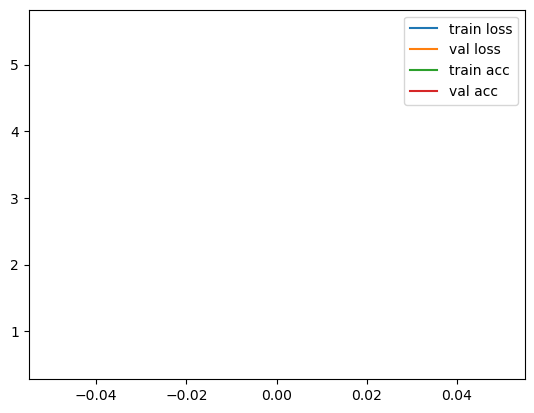

2.5128565 1.468762367963791 0.63346356 0.593125.6666666865348816
1.9737445 2.486425533890724 0.655599 0.553125 0.8333333730697632
1.1272794 2.34842512011528 0.6875 0.5453125c: 1.02555
1.2867167 2.4906520545482635 0.7011719 0.554062558755
1.7470953 4.348244875669479 0.655599 0.57875: 0.3333333432674408
0.92547554 2.1369872987270355 0.7207031 0.58531253755
1.6538267 2.7393781542778015 0.6842448 0.62093747666666865348816
1.01476 2.147333785891533 0.7089844 0.62093747.581255
1.7858267 2.534639686346054 0.7526042 0.6453125666666865348816
1.0385501 2.7067643105983734 0.7760417 0.63875 0.6666666865348816


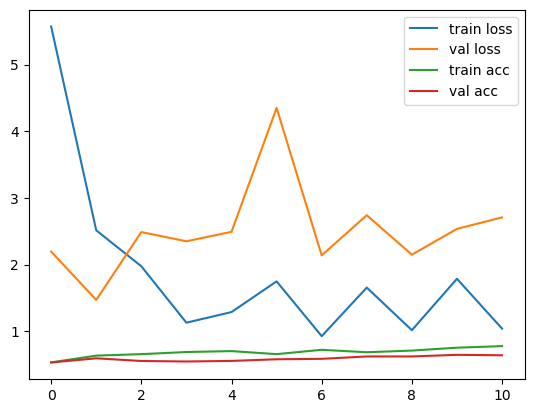

0.76328856 2.024142548441887 0.7734375 0.63cc: 0.518755
0.6808883 2.035610467195511 0.78515625 0.6365624751255
0.83913624 2.799386605620384 0.8125 0.61875Acc: 1.0525
0.6130528 3.914543315768242 0.79557294 0.6243750.6666666865348816
0.7808296 3.8241387009620667 0.84375 0.6165625: 1.04375
0.63300544 3.9689312875270844 0.80794275 0.62093747333333730697632
0.58451486 3.621642842888832 0.8496094 0.63656247.0255
1.0058031 4.734648257493973 0.859375 0.65999997 1.0625
0.84800935 4.215477183461189 0.8372396 0.63875: 0.8333333730697632


In [83]:
for epoch in range(train_config['num_epochs']):
    los, acc = train_one_epoch(model, optimizer, criterion, trainloader, epoch)
    train_losses.append(los)
    train_accs.append(acc)
    los, acc = validate(model, valloader, criterion)
    val_losses.append(los)
    val_accs.append(acc)
    print(train_losses[-1], val_losses[-1], train_accs[-1], val_accs[-1])
    if epoch % 10 == 0:
        plt.plot(train_losses, label="train loss")
        plt.plot(val_losses, label="val loss")
        plt.plot(train_accs, label="train acc")
        plt.plot(val_accs, label="val acc")
        plt.legend()
        plt.show()

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.plot(train_accs, label="train acc")
plt.plot(val_accs, label="val acc")
plt.legend()
plt.show()